# Ensemble of networks

In [1]:
import torch
import torchvision
import copy
from tqdm import trange
import cv2
from torchvision import transforms
from torch.utils.data import random_split, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)

device = torch.device("cpu")

print(device)

cpu


In [2]:
train_transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((64, 64)),
    transforms.PILToTensor()
    
])

test_transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.Resize((64, 64)),
    transforms.PILToTensor()
])

In [3]:
BATCH_SIZE = 32

trainset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=Image.open)

trainset_classes = trainset.classes.copy()

subset_size = int(0.15*len(trainset))

validset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/train/', loader=Image.open)

indices = torch.randperm(len(trainset))

valid_indices = indices[:subset_size]
train_indices = indices[subset_size:]

trainset = Subset(trainset, train_indices)
validset = Subset(validset, valid_indices)

# Apply transformations only to the training set
trainset.dataset.transform = train_transform
# Apply transformations to the validation set
validset.dataset.transform = test_transform

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='CVPR2023_project_2_and_3_data/test/', transform=test_transform, loader=Image.open)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True) # batch size of 1 because we have to crop in order to get all images to same size (64x64), also see pin_memory optin

print(f'entire train folder: {len(trainset)}, entire test folder: {len(testset)}, splitted trainset: {len(trainset)},  splitted validset: {len(validset)}')

entire train folder: 1275, entire test folder: 2985, splitted trainset: 1275,  splitted validset: 225


In [4]:
# default 3, 3, 3 and linear 32*12*12

class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(16),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(32),
                torch.nn.MaxPool2d(kernel_size=2, stride=2),
                torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
                torch.nn.BatchNorm2d(64),
                torch.nn.ReLU()
        )
        
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(64*12*12, 15)
        )

    def forward(self, x):
        x = x.float()
        return self.classifier(self.conv(x))

model = CNN().to(device)

In [5]:
def initialize_weigths_and_bias(m):
  if (type(m) == torch.nn.Linear) or (type(m) == torch.nn.Conv2d):
      torch.nn.init.constant_(m.bias.data, 0) # initialize weights
      torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.01)
  

model.apply(initialize_weigths_and_bias)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=15, bias=True)
  )
)

In [6]:
# The same plotting function from the previous lab
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

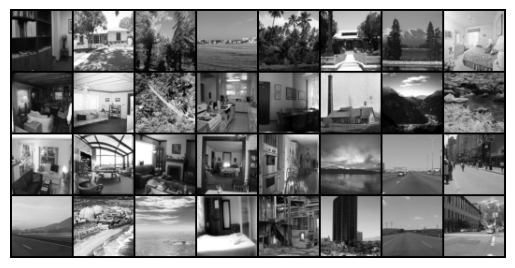

In [7]:
images, labels = next(iter(trainloader))

imshow(torchvision.utils.make_grid(images))

In [8]:
# Checking initialization printing mean, std, max biases in the classifier fully connected layer

model.classifier[1].weight.mean(), model.classifier[1].weight.std(), model.classifier[1].bias.max()

(tensor(-1.5502e-05, grad_fn=<MeanBackward0>),
 tensor(0.0100, grad_fn=<StdBackward0>),
 tensor(0., grad_fn=<MaxBackward1>))

In [9]:
# Checking initialization printing mean, std, max biases in the first convolution layer

model.conv[0].weight.mean(), model.conv[0].weight.std(), model.conv[0].bias.max()

(tensor(-0.0003, grad_fn=<MeanBackward0>),
 tensor(0.0105, grad_fn=<StdBackward0>),
 tensor(0., grad_fn=<MaxBackward1>))

In [10]:
def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return correct/len(dataloader.dataset)

In [11]:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [12]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0
    for x, y in iter(loader):
        x = x.to(device)
        y = y.to(device)
        out=model(x)
        l=loss(out, y)
        running_loss += l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    return running_loss/len(loader.dataset)
    

In [13]:
def get_test_predictions(model, test_loader):
    pred_tens = torch.empty(len(test_loader.dataset), dtype=torch.uint8)
    labels_tens = torch.empty_like(pred_tens)

    for i, data in enumerate(test_loader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
        prediction = model(x)

        prediction = torch.argmax(prediction, axis=1)

        # Calculate the proper indices for assignment
        start_idx = i * test_loader.batch_size
        end_idx = start_idx + x.size(0)
    
        pred_tens[start_idx:end_idx] = copy.deepcopy(prediction)
        labels_tens[start_idx:end_idx] = copy.deepcopy(y)
    
    return (pred_tens, labels_tens)

## Enseble test prediction

This function returns the best class according to the whole ensemble of networks, this is done by averaging the probability distribution of the output of the various models (we sofmax all of them in order to have a true probability distribution) and taking the label with the maximum probability. This is a simple way to implement a sort of voting but we can imagine that it's sensible to "outliers", in fact even if the empirical accuracy of a NN is 7% (random classifier) it's weighted as one with 99%. The point is that if a network with a low accuracy gives an high wrong output this drifts the result.

In [14]:
def get_ensemble_test_predictions(model_list, test_loader):
    pred_tens = torch.empty(len(test_loader.dataset), dtype=torch.uint8)
    labels_tens = torch.empty_like(pred_tens)

    for i, data in enumerate(test_loader):
        x, y = data
        x = x.to(device)
        y = y.to(device)

        ensemble_pred = torch.empty((len(model_list), x.size(0), 15))
        
        for j, model in enumerate(model_list):
            model.eval()
            pred = model(x).softmax(dim=1)
            ensemble_pred[j] = pred
        
        mean_prediction = ensemble_pred.mean(dim=0)

        prediction = torch.argmax(mean_prediction, axis=1)

        # Calculate the proper indices for assignment
        start_idx = i * test_loader.batch_size
        end_idx = start_idx + x.size(0)
        pred_tens[start_idx:end_idx] = copy.deepcopy(prediction)
        labels_tens[start_idx:end_idx] = copy.deepcopy(y)
    
    return (pred_tens, labels_tens)

In [15]:
'''
votes = ensemble_pred[:, 0]
voted_classes_and_count = votes.unique(return_counts=True)
most_voted_classes_index = torch.argwhere(voted_classes_and_count[1] == torch.max(voted_classes_and_count[1]))
most_voted_classes = voted_classes_and_count[0][most_voted_classes_index]
final_prediction = most_voted_classes[0, 0].to(torch.uint8)
if most_voted_classes.size(0) >= 2:
    unique_elements = torch.unique(votes)
    unique_classes_with_prob = torch.zeros((unique_elements.size(0), 2))
    for i, element in enumerate(unique_elements):
        mask = ensemble_pred[:, 0] == element
        unique_classes_with_prob[i, 0] = element
        unique_classes_with_prob[i, 1] = torch.sum(ensemble_pred[mask, 1])
    final_prediction = unique_classes_with_prob[:, 0][torch.argmax(unique_classes_with_prob[:, 1], dim=0)].to(torch.uint8)
'''

'\nvotes = ensemble_pred[:, 0]\nvoted_classes_and_count = votes.unique(return_counts=True)\nmost_voted_classes_index = torch.argwhere(voted_classes_and_count[1] == torch.max(voted_classes_and_count[1]))\nmost_voted_classes = voted_classes_and_count[0][most_voted_classes_index]\nfinal_prediction = most_voted_classes[0, 0].to(torch.uint8)\nif most_voted_classes.size(0) >= 2:\n    unique_elements = torch.unique(votes)\n    unique_classes_with_prob = torch.zeros((unique_elements.size(0), 2))\n    for i, element in enumerate(unique_elements):\n        mask = ensemble_pred[:, 0] == element\n        unique_classes_with_prob[i, 0] = element\n        unique_classes_with_prob[i, 1] = torch.sum(ensemble_pred[mask, 1])\n    final_prediction = unique_classes_with_prob[:, 0][torch.argmax(unique_classes_with_prob[:, 1], dim=0)].to(torch.uint8)\n'

## Model definition

Here we employ a list to define 5 models, in order to train an enseble of networks

In [16]:
MAX_NETS = 5
ensemble_net = [CNN().to(device) for i in range(MAX_NETS)]
# opt_list = [torch.optim.SGD(ensemble_net[i].parameters(), lr=0.001, momentum=0.9) for i in range(len(ensemble_net))]
opt_list = [torch.optim.Adam(ensemble_net[i].parameters(), lr=0.001) for i in range(len(ensemble_net))]

for i in range(len(ensemble_net)):
    ensemble_net[i].apply(initialize_weigths_and_bias)

In [17]:
# This function trains the ensemble of networks and return the relative losses and accuracies

def train_ensemble_network(model_list, epochs, opt_list):
    losses = np.empty((len(model_list), epochs))
    accuracies = np.empty_like(losses)
    for epoch in trange(epochs, desc="Training: ", unit="epoch"):
        for i in range(len(model_list)):
            accuracy = get_accuracy(model_list[i], validloader)
            accuracies[i][epoch] = accuracy
            curr_loss = train_one_epoch(model_list[i], trainloader, opt_list[i])
            losses[i][epoch] = curr_loss
    
    for i in range(len(model_list)):
        print(f"Final accuracy: {get_accuracy(model_list[i], validloader)}")
    
    return accuracies, losses

In [18]:
accuracies, losses = train_ensemble_network(model_list=ensemble_net, epochs = 50, opt_list=opt_list)

Training: 100%|██████████| 50/50 [12:17<00:00, 14.75s/epoch]


Final accuracy: 0.3333333432674408
Final accuracy: 0.5555555820465088
Final accuracy: 0.5288888812065125
Final accuracy: 0.5911111235618591
Final accuracy: 0.5866666436195374


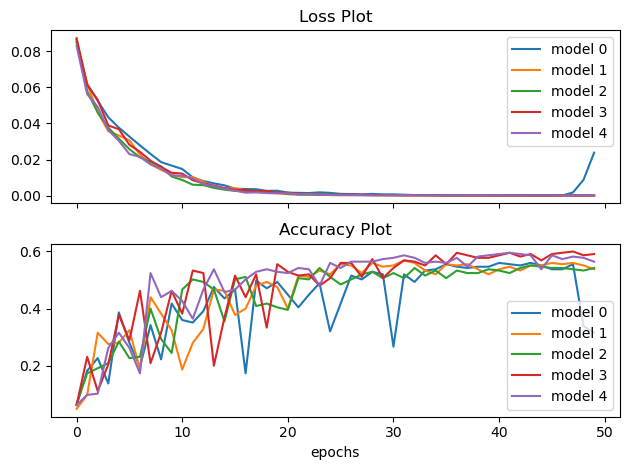

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot data on the first subplot

for i in range(MAX_NETS):
    ax1.plot(losses[i], label="model " + str(i))

ax1.set_title('Loss Plot')
ax1.legend()

# Plot data on the second subplot

for i in range(MAX_NETS):
    ax2.plot(accuracies[i], label="model " + str(i))
    
ax2.set_title('Accuracy Plot')
ax2.legend()

# Add a common x-axis label
plt.xlabel('epochs')
plt.tight_layout()

# Show the plot
plt.show()

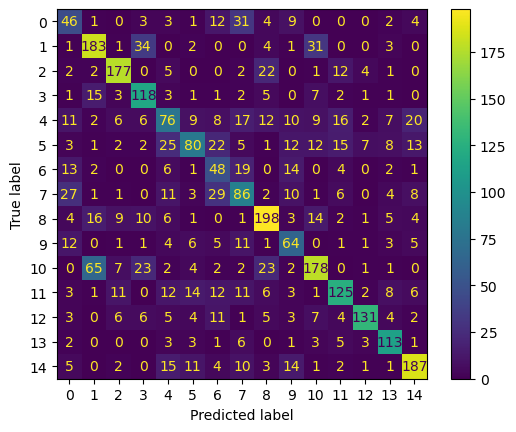

In [20]:
# Here we are calculating the cofusion matrix

pred_tensor, labels_tensor = get_ensemble_test_predictions(ensemble_net, testloader)

pred_array = pred_tensor.numpy()
labels_array = labels_tensor.numpy()

cm = confusion_matrix(labels_array, pred_array, labels=[*range(0, len(trainset_classes))])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*range(0, len(trainset_classes))])

disp.plot()

plt.show()

In [21]:
# Here we are loading the best early stopping ensemble of networks

es_ensemble_net = [CNN().to(device) for i in range(MAX_NETS)]
# es_opt_list = [torch.optim.SGD(es_ensemble_net[i].parameters(), lr=0.001, momentum=0.9) for i in range(len(ensemble_net))]
es_opt_list = [torch.optim.Adam(es_ensemble_net[i].parameters(), lr=0.001) for i in range(len(ensemble_net))]


for i in range(len(ensemble_net)):
    es_ensemble_net[i].apply(initialize_weigths_and_bias)

## Early Stoping

This loop is a simple early stopping implemetation; it uses GL as a stopping criterion to know if we are "overfitting" model.
At every iteration it checks each single model in the network and save it when it enbetters itself

In [22]:
folder = 'es_models/'

model_name = 'best_model'

In [23]:
GL = lambda val_err, opt_err: 100*((val_err/opt_err) - 1) # GL measure based on the cited paper

def es_train_ensemble_net(model_list, epochs, opt_list, save_path='es_models/'):
	losses = np.ones((len(model_list), epochs)) * (-1)
	accuracies = np.ones_like(losses) * (-1)

	optimal_error = np.ones(len(model_list)) * np.inf
	validation_error = np.zeros_like(optimal_error)

	alpha = 100

	epoch = 0

	indexes_to_train = [i for i in range(len(model_list))]
	
	while(len(indexes_to_train) > 0 and epoch < epochs):

		clear_output(wait=True)

		is_time_to_early_stop = GL(validation_error, optimal_error) < alpha
		indexes_to_train = np.where(is_time_to_early_stop == True)[0].tolist()

		alpha *= 0.95
		
		for i in indexes_to_train:

			curr_loss = train_one_epoch(model_list[i], trainloader, opt_list[i])
			losses[i][epoch] = curr_loss

			accuracy = get_accuracy(model_list[i], validloader)
			accuracies[i][epoch] = accuracy
			
			validation_error[i] = 1 - accuracy

			print(f"Model: {i}, Epoch: {epoch : 04d}, Test loss: {curr_loss : .05f}, GL: {GL(validation_error, optimal_error)}, error: {validation_error}")

			if validation_error[i] < optimal_error[i]:
				path = save_path + model_name + str(i) + ".pt"
				optimal_error[i] = validation_error[i]
				torch.save({
			    	"model_state_dict": model_list[i].state_dict(),
			    	"optimizer_state_dict": opt_list[i].state_dict()
				}, path)
		
		epoch += 1


	return (accuracies, losses)

In [24]:
accuracies, losses = es_train_ensemble_net(es_ensemble_net, 1000, es_opt_list)

Model: 4, Epoch:  056, Test loss:  0.00006, GL: [40.20618999 38.14433161 27.2727285  48.14813343  6.06060031], error: [0.60444444 0.59555554 0.56       0.71111107 0.46666664]


In [25]:
es_ensemble_net = [CNN().to(device) for i in range(MAX_NETS)]

tmp_path = folder + model_name

checkpoints = [torch.load(tmp_path + str(i) + ".pt") for i in range(MAX_NETS)]

for i in range(MAX_NETS):
    es_ensemble_net[i].load_state_dict(checkpoints[i]["model_state_dict"])
    print(f"Final accuracy: {get_accuracy(es_ensemble_net[i], validloader)}")

Final accuracy: 0.5688889026641846
Final accuracy: 0.5688889026641846
Final accuracy: 0.5600000023841858
Final accuracy: 0.5199999809265137
Final accuracy: 0.5600000023841858


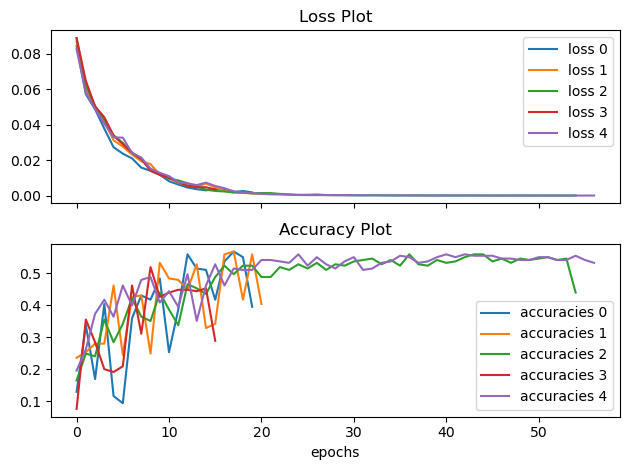

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot data on the first subplot
for i in range(MAX_NETS):
    indexes = np.where(losses[i] > 0)[0].tolist()
    ax1.plot(losses[i][indexes], label = "loss " + str(i))
ax1.set_title('Loss Plot')
ax1.legend()

# Plot data on the second subplot
for i in range(MAX_NETS):
    indexes = np.where(accuracies[i] > 0)[0].tolist()
    ax2.plot(accuracies[i][indexes], label = "accuracies " + str(i))
ax2.set_title('Accuracy Plot')
ax2.legend()

# Add a common x-axis label
plt.xlabel('epochs')
plt.tight_layout()

# Show the plot
plt.show()

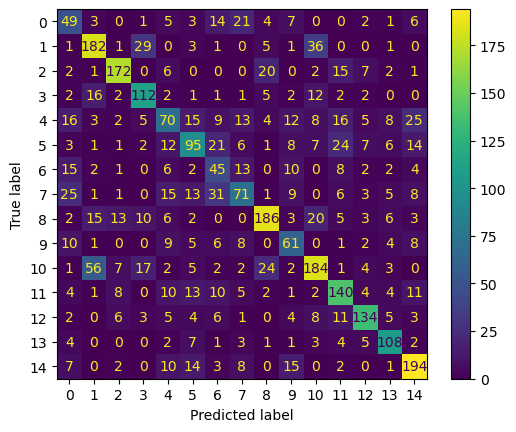

In [27]:
pred_tensor, labels_tensor = get_ensemble_test_predictions(es_ensemble_net, testloader)
# pred_tensor, labels_tensor = get_test_predictions(ensemble_net[2], testloader)

pred_array = pred_tensor.numpy()
labels_array = labels_tensor.numpy()

cm = confusion_matrix(labels_array, pred_array, labels=[*range(0, len(trainset_classes))])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[*range(0, len(trainset_classes))])

disp.plot()

plt.show()

## Printing dataset classes and respective number of elemts per class

In [27]:
trainset_classes

['Bedroom',
 'Coast',
 'Forest',
 'Highway',
 'Industrial',
 'InsideCity',
 'Kitchen',
 'LivingRoom',
 'Mountain',
 'Office',
 'OpenCountry',
 'Store',
 'Street',
 'Suburb',
 'TallBuilding']

In [28]:
## Stampa numero immagini per classe per vedere se dataset è bilanciato
np.sum(cm, axis=1)

array([116, 260, 228, 160, 211, 208, 110, 189, 274, 115, 310, 215, 192,
       141, 256], dtype=int64)